In [2]:
from dateutil import parser
import sqlite3
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import statistics as st
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.style.use('ggplot')
#mimics the ggplot feel from R
#%matplotlib inline

# In this notebook, I have imported a public dataset listing info of every Chicago government employee including department and salary
### From there, I create a database of all full time employees and plot various data points using matplotlib

## Creating the database:

In [3]:
empdf = pd.read_csv(
    "C:\\Users\\Declandre\\Chicago data\\sourcedata\\Current_Employee_Names__Salaries__and_Position_Titles.csv")

empdf = empdf.rename(columns={
    'Job Titles': 'jobs',
    'Department':'dept',
    'Salary or Hourly':'isSalaried',
    'Full or Part-Time':'isFT',
    'Typical Hours' : 'regHrs',
    'Annual Salary' : 'salary',
    'Hourly Rate' : 'hrRate'
    })

empdf['isFT'] = empdf['isFT'].replace(['F','P'],[True,False])
empdf['isSalaried'] = empdf['isSalaried'].replace(['Salary','Hourly'],[True,False])
empdf['salary'] = empdf['salary'].fillna(empdf['hrRate']*empdf['regHrs']*52).astype(int)


a = len(empdf['Name'])
b = len(empdf['Name'].unique())
empdf = empdf.sort_values('dept')


ftdf = empdf.loc[empdf['isFT'] == True]
ptdf = empdf.loc[empdf['isFT'] == False]

ftdf = ftdf.loc[ftdf['dept'].isna() == False]
dept_list = ftdf['dept'].unique()
col_list = ftdf.columns
#col_list  

#### Create functions to format graph labels: 

In [4]:
def currency(x, pos):
    #The two arguments are the value and tick position
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

def addCommas(x,pos):
    x = round(x)
    return "{:,}".format(x)

def properize(names):
    properList = []
    for name in names:
        properList.append(name.title())
    return properList

## Creating full-time employee salary statistics by department table:

In [5]:
def salaryStatisticsByDept():
    salary_by_department_empty =        {'department': [], 'numEmployees':[], 'salaryAvg': [], 'salaryMax': [], 
                                         'salaryMin': [], 'salaryRange': [], 'salarySTDEV': [], }

    for department in dept_list:
        seriesName = department + ' Yearly Salary Statistics'
        dept_sal_list = pd.Series(ftdf['salary'].loc[ftdf['dept'] == department], index=None)
        salaryAvg = round(np.mean(dept_sal_list),2)
        salaryMax = np.max(dept_sal_list)
        salaryMin = np.min(dept_sal_list)
        salaryRange = salaryMax -salaryMin
        salarySTDEV = np.std(dept_sal_list)
        numEmployees = len(dept_sal_list)
        salary_by_department_empty['department'].append(department)
        salary_by_department_empty['salaryAvg'].append(salaryAvg)
        salary_by_department_empty['salarySTDEV'].append(salarySTDEV)
        salary_by_department_empty['salaryRange'].append(salaryRange)
        salary_by_department_empty['salaryMin'].append(salaryMin)
        salary_by_department_empty['salaryMax'].append(salaryMax)
        salary_by_department_empty['numEmployees'].append(numEmployees)
        dollars = [salaryAvg,salaryMax,salaryMin,salaryRange,salarySTDEV]
        dollars_formatted = map(lambda x: "${:.1f}k".format((x/1000)),dollars)
        
    ftSalaryByDept = pd.DataFrame.from_dict(salary_by_department_empty)
    ftSalaryByDept = ftSalaryByDept.set_index('department')
    
    ftSalaryByDept['salaryAvg_formatted'] = ftSalaryByDept['salaryAvg'].apply(lambda x: "${:.1f}k".format((x/1000)))
    return ftSalaryByDept

ftSalaryByDept = salaryStatisticsByDept()
#ftSalaryByDept.sort_values('numEmployees', ascending=False)
#ftSalaryByDept.head()
#def salaryRangeByDept():
#for department in dept_list:


## Average Employee Salary of 10 Largest Departments:

#### Gathering the data:

In [6]:
top10dept =ftSalaryByDept.sort_values('numEmployees', ascending=False).head(10)

data3 = top10dept.sort_values('salaryAvg',ascending=True)
x_titles = properize(list(data3.index))
#data3.head(10)

#### Creating the graph:

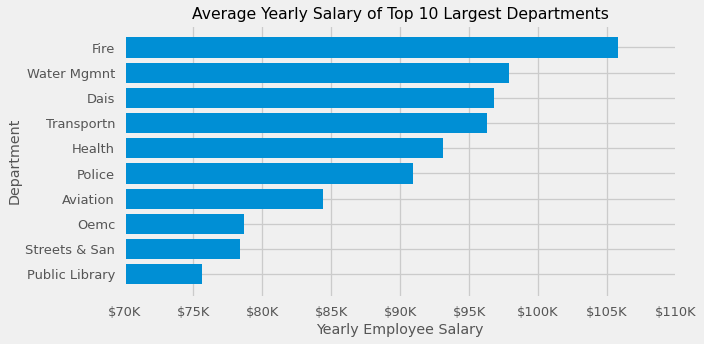

In [15]:
plt.style.use('seaborn-talk')
fig,ax = plt.subplots(figsize=(10,5))
ax.set(title='Average Yearly Salary of Top 10 Largest Departments',
       xlabel='Yearly Employee Salary',
       ylabel='Department',
       xlim=[70000,110000])
ax.xaxis.set_major_formatter(currency)
ax.barh(x_titles,data3['salaryAvg'])
#print(plt.style.available)
plt.show()

### Average salary vs number of employees:

#### Creating the graph:

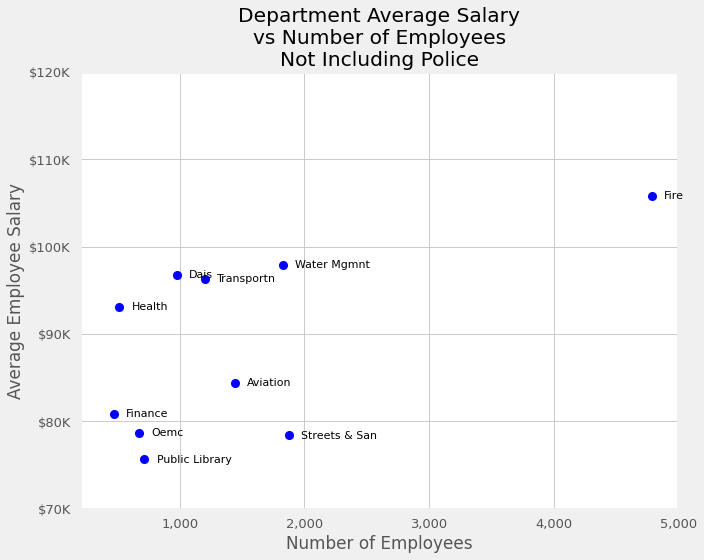

In [13]:
data5 = ftSalaryByDept.sort_values('numEmployees', ascending=False)
matplotlib.rcParams['figure.autolayout'] = True

#Remove outliers:
data5 = data5.loc[data5.index != 'POLICE']
data5 = data5.loc[data5.numEmployees > 400]
data5['payroll'] = data5['numEmployees'] * data5['salaryAvg']

#Create figure:
fig, ax = plt.subplots(figsize=(10,8))

#set style:
plt.style.use('fivethirtyeight')

#create axes:
ax.plot('numEmployees','salaryAvg','bo',data=data5)
ax.set(xlabel='Number of Employees',ylabel='Average Employee Salary',
       xlim=[200,5000],
       ylim=[70000,120000],
       facecolor='white'
       )
#format x and y axis:
ax.yaxis.set_major_formatter(currency)
ax.xaxis.set_major_formatter(addCommas)
ax.grid(True)
ax.set(title='Department Average Salary\nvs Number of Employees\nNot Including Police')

# Annotate departments:
for group in list(data5.index):
    ax.text(data5.numEmployees[data5.index==group]+100,
            data5.salaryAvg[data5.index==group],s=group.title(),
            fontdict=dict(color='black', alpha=1, size=11,verticalalignment='center'))
  
plt.show()

## Employee Salary Spread of 5 Largest Departments:

#### Gathering the data:

In [10]:
#list of top 5 departments by number of employees:
top5dept =ftSalaryByDept.sort_values('numEmployees', ascending=False).head(5).index

#set empty lists for loops later
dept_name =[]
data = []

data1 = pd.DataFrame(index=top5dept,columns=['salary_list','salary_avg','median_salary'])
for i in top5dept:
    tempdata = list(ftdf.salary.loc[ftdf['dept'] == i])
    aver = (sum(tempdata) / len(tempdata))
    med = np.median(tempdata)
    data1['salary_list'].loc[i] = tempdata
    data1['salary_avg'].loc[i] = aver
    data1['median_salary'].loc[i] = aver

data1['numEmployees'] = ftSalaryByDept['numEmployees'].loc[data1.index]
data1 = data1.sort_values('salary_avg',ascending=False)

dept_name_proper = properize(list(data1.index))

#### Creating the boxplot:

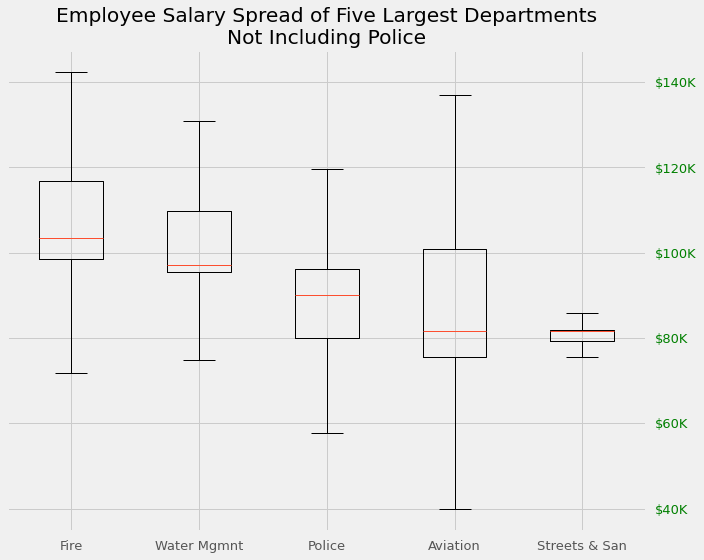

In [12]:
test = np.random.randn(50)


#set figure size
plt.rcParams["figure.figsize"] = (10,8)

fig3,ax3 = plt.subplots()
ax3.boxplot(data1['salary_list'],showfliers=False)

numDataPoints = list(range(1,len(top5dept)+1))
plt.xticks(numDataPoints, dept_name_proper)
plt.title('Employee Salary Spread of Five Largest Departments\nNot Including Police')
ax3.yaxis.set_major_formatter(currency)
ax3.yaxis.set_tick_params(which='major', labelcolor='green',
                         labelleft=False, labelright=True)

